## Evaluating hybrid CMPCs on Binary MNIST

❗ I don't suggest evaluating these models using commerical GPUs unless you are friendly with NVIDIA and have early access to some powerful commercial GPUs.

❗ I suggest using a compute cluster in which you can utilise a GPU at least as powerful as a 32 GB V100.

### Directory shenanigans

The repo's directory is very possibly dependent on where the workspace is stored on your device. Ideally, running this first block will assign `/cm-tpm-main/` to `repo_dir`.

In [1]:
import os
import sys

# 1. repo_dir used later
repo_dir = os.path.abspath(os.path.join(os.path.abspath("")))

# 2. sys.path must be appended for importing modules
sys.path.append(repo_dir)

# 3. fix current working directory
os.chdir(os.path.abspath(os.path.join(os.path.abspath(""))))

### Import libaries + assign device (CPU/GPU)

It's unlikely that you need to change any of this. Simply run it.

In [2]:
from models.cm_hybrid import ContinuousMixture
from models.lo_hybrid import bins_lo, fast_bins_lo
from torch.utils.data import DataLoader
from torchvision import datasets
from utils.reproducibility import seed_everything

import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# assign device (cpu or gpu, if present)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load data

It's unlikely that you need to change any of this. Simply run it.

In [3]:
# choose True for MNIST and False for Binary MNIST (all benchmarks discussed in the report are for Binary MNIST so it is set to False by default here)
use_mnist = False
dataset = 'mnist' if use_mnist else 'bmnist'

# create data directory (if not done already)
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# download MNIST into data directory (if not done already)
mnist_test = datasets.MNIST(root="data", train=False, download=True)
labels_mnist_test = mnist_test.targets

# convert dataset to tensor
mnist_test = mnist_test.data.view(10_000, 784).float()

# define test set and binarise if use_mnist is False
X_test = mnist_test if use_mnist else (mnist_test / 255 >= 0.5).float()
y_test = labels_mnist_test

# load val and test sets into dataloaders
batch_size = 128
test_loader = DataLoader(X_test, batch_size=batch_size)

### Load model

Set the hyperparameters according to which model you would like to evaluate. To see which are available have a look in ```/logs/bmnist/hybrid```.

#### **Example:**

Perhaps today I feel like benchmarking the hybrid CMPC with latent dimension $d=16$, $N_{\text{train}}=2^{13}$ and $\lambda=0.4$.

I see that this model is trained and ready to be evaluated as the directory `/logs/bmnist/hybrid/latent_dim_16/num_bins_8192/lambda_0.40` exists.

As such, I choose `latent_dim=16`, `num_bins_trained=8_192` and `lambda=0.4` below. I suggest leaving the rest of the block alone and running it. If successful you will see a printed string along the lines of
$$\texttt{/cm-tpm-main/logs/bmnist/hybrid/latent\_dim\_16/num\_bins\_8192/lambda\_0.40/version\_0/checkpoints/best\_model\_valid-epoch=66.ckpt}.$$
If the `UserWarning` is printed too, ignore it. It has no effect on our evaluation and is simply PyTorch being temperamental.

In [10]:
# model hyperparams (change these according to which model you would like to evaluate)
latent_dim = 32
num_bins_trained = 8_192
lamda = 0.0

# load model
version_num = 0 # don't change this from 0 if you're unaware of what it does
model_path = glob.glob(repo_dir+f'/logs/{dataset}/hybrid/latent_dim_{latent_dim}/num_bins_{num_bins_trained}/lambda_{lamda:.2f}/version_{version_num}/checkpoints/*.ckpt')[0]
model = ContinuousMixture.load_from_checkpoint(model_path).to(device)
model.n_chunks = 32
model.missing = False # this was True before, check if difference (hope not)
model.eval(); # semi-colon to prevent printing model architecture
print(model_path)

/scratch/s3313093/cm-tpm-main/logs/bmnist/hybrid/latent_dim_32/num_bins_8192/lambda_0.00/version_0/checkpoints/best_model_valid-epoch=82.ckpt


/home2/s3313093/venvs/my_env/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208


### Function for computing mean negative log-likelihoods and clasisfication accuracies

Best to minimise this block as it takes a lot of vertical space and makes scrolling up and down between blocks inconvenient when not minimised.

In [5]:
def compute_accuracies(
    model,
    X_test,
    y_test,
    lower_power_bound,
    upper_power_bound,
    latent_opt,
    use_mnist,
    missing_rate,
    batch_size=512,
    seed=42,
):
    accuracies = []
    n_bins_list = [2 ** k for k in range(lower_power_bound, upper_power_bound)]

    seed_everything(seed)
    test_lls = []
    for n_bins in n_bins_list:
        model.sampler.n_bins = n_bins
        if latent_opt:
            z, log_w = bins_lo(model, n_bins, train_loader, valid_loader, max_epochs=20, lr=1e-3, patience=5, device=device)
        else:
            z, log_w = model.sampler(seed=seed)

        all_ll = torch.zeros(len(X_test), 10)

        if missing_rate == 0.0:
            # if no missingness, we can evaluate log‐likelihood directly
            test_lls.append(-model.eval_loader(test_loader, z, log_w, device=device).mean().item())

        # ————— prepare a single mask for all digits —————
        if missing_rate != 0.0:
            model.missing = True
            # draw one mask of the same shape as X_test
            # so that the same entries are "missing" under every digit‐label hypothesis
            mask = torch.rand_like(X_test) < missing_rate
        else:
            mask = None

        for digit in range(10):
            # start from clean copy of X_test each time
            Xd = X_test.clone()

            # apply the pre–computed mask (if any) so it is identical for all digit loops
            if mask is not None:
                Xd[mask] = float('nan')

            # overwrite label channels with this candidate digit
            if use_mnist:
                Xd[:, -1] = digit
            else:
                bitstring = [int(b) for b in bin(digit)[2:].zfill(4)]
                Xd[:, -4:] = torch.tensor(bitstring, dtype=torch.float)

            loader = DataLoader(Xd, batch_size=batch_size, shuffle=False)
            ll_chunks = []
            with torch.no_grad():
                for xb in loader:
                    xb = xb.to(device)
                    llb = model.forward(xb, z, log_w, k=None, seed=seed)
                    ll_chunks.append(llb.cpu())
            all_ll[:, digit] = torch.cat(ll_chunks, dim=0)

        # classification by maximum log‐likelihood
        preds = all_ll.argmax(dim=1)
        acc = (preds == y_test.squeeze()).float().mean().item()
        accuracies.append(acc)

    if latent_opt:
        return n_bins_list, accuracies, z

    return n_bins_list, accuracies, test_lls

### Evaluation time! Compute mean negative log-likelihoods and classification accuracies on the test set

- The single hybrid CMPC evaluated here is fixed according to whichever model was loaded above
- The number of components $N_{\text{test}}$ varies according to $\texttt{lower\_power\_bound}$ and $\texttt{upper\_power\_bound}$
- Classification is performed on the test set for various portions of pixels being missing at random. The portion of pixels missing is dictated by the list $\texttt{missing\_rates}$.

#### **Example:**
If we loaded the model with latent dimension $d=16$, $\texttt{num\_bins\_trained}=2^{13}$ and $\lambda=0.4$ then the model being evaluated on the test set in this block is precisely the hybrid CMPC trained with $N_{\text{train}}=2^{13}$, $d=16$ and $\lambda=0.4$. As stated in the report, the number of components at test time $N_{\text{test}}$ can be whatever we desire, so in the block below we evaluate our hybrid CMPC at test time with $N_{\text{test}}\in\{2^8,\dots,2^{14}\}$ (so 7 models are evaluated). As such, the block outputs the mean negative log-likelihood and classification accuracy of each of our 7 models.

Further, we evaluate the classification accuracies of these 7 test time models for varying degrees of missing pixel values in each sample. By default, we perform this evaluation for the following list of portions of missing pixel values: $0\%, 10\%, 20\%,\dots, 90\%, 95\%$ (11 distinct portions in total). As such, for each of our 7 evaluated models, we expect the block to return a single mean negative log-likelihood and 11 classification accuracies. The order of the latter is according to the portions of missing pixel values from $0\%$ to $95\%$.

❗This block takes about 15 minutes to run on a 40 GB A100 GPU.

In [ ]:
missing_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
acc_dict = {k: [] for k in missing_rates}
test_lls = []

for missing_rate in missing_rates:
    n_bins_list, acc_list, test_lls_list = compute_accuracies(
        model=model,
        X_test=X_test,
        y_test=y_test,
        lower_power_bound=8,
        upper_power_bound=15, # reduce this to 9 to speed up debugging
        latent_opt=False,
        use_mnist=use_mnist,
        missing_rate=missing_rate,
    )
    if missing_rate == 0.0:
        test_lls = test_lls_list
    acc_dict[missing_rate] = acc_list

print(f"latent_dim_{latent_dim}/n_bins_{num_bins_trained}/epoch_{int(model_path.split('epoch=')[-1].split('.', 1)[0])} - LAMBDA {lamda:.2f}")
for i in range(len(n_bins_list)):
    n_bins = n_bins_list[i]
    str_to_print = f"Accuracy for {n_bins:5d} components: {test_lls[i]:8.4f}"
    for missing_rate in missing_rates:
        str_to_print += f" : {acc_dict[missing_rate][i]:.4f}"
    print(str_to_print)

### Plot classification accuracies from block above (one curve for each $N_{\text{test}}\in\{2^8,\dots,2^{14}\}$)

In [ ]:
# convert missing rates to percentages
missing_rates_pct = [m * 100 for m in missing_rates]
perf_matrix_pct = (np.array([acc_dict[m] for m in missing_rates]) * 100).T

plt.figure(figsize=(6, 4))
for idx, temp in enumerate(n_bins_list):
    plt.plot(
        missing_rates_pct,
        perf_matrix_pct[idx],
        linestyle='--',
        marker='o',
        markersize=4,
        linewidth=2.5,
        label=str(temp),
    )

# axis labels
plt.xlabel("Pixel values missing at random (%)", fontsize=10)
plt.ylabel("Accuracy (%)", fontsize=10)

# x‐ticks
plt.xticks(missing_rates_pct, fontsize=9)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('#888888')
    ax.spines[spine].set_linewidth(0.8)

# dynamically changed y‐axis: from min accuracy up to 100%
y_min = perf_matrix_pct.min()
y_min_tick = int(np.floor(y_min / 10) * 10) # round down to nearest 10
ax.set_yticks(np.arange(y_min_tick, 101, 10)) # ticks every 10%
ax.yaxis.grid(True, linestyle='--', linewidth=1.0, color='#bbbbbb')
ax.set_ylim(y_min, 100)
plt.yticks(fontsize=9)

# force legend to appear in top right
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.0085), frameon=True, edgecolor='#888888', facecolor='white', fontsize=8)
plt.tight_layout(pad=0.5)

plt.savefig(f"figures/accuracies/lambda_fixed/accs_latent_dim_{latent_dim}_lam_{lamda}.png")
plt.savefig(f"figures/accuracies/lambda_fixed/accs_latent_dim_{latent_dim}_lam_{lamda}.pdf")
plt.show()

### Plot classification accuracies for fixed number of components and varying lambdas

Here, for $\lambda\in\{0,0.2,0.4,0.6,0.8,1\}$, $N_{\text{test}}=2^{14}$ and whichever latent dimension $d\in\{2,4,8,16,32\}$ you desire. For the fixed latent dimension chosen, this block computes the classification accuracies for 6 models: one for each value of $\lambda$. Again, classification is performed for the test set with various portions of missing pixel values.

To change the latent dimension, set `latent_dim` to $2,4,8,16$ or $32$.

❗This block takes about 40 minutes to run on a 40 GB A100 GPU.

In [6]:
# model hyperparams
latent_dim = 32
num_bins_trained = 8_192
version_num = 0

lamdas = [0, 0.2, 0.4, 0.6, 0.8, 1]
missing_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

acc_dict = {k: [] for k in lamdas}
for lamda in lamdas:

    # load model
    model_path = glob.glob(repo_dir+f'/logs/{dataset}/hybrid/latent_dim_{latent_dim}/num_bins_{num_bins_trained}/lambda_{lamda:.2f}/version_{version_num}/checkpoints/*.ckpt')[0]
    model = ContinuousMixture.load_from_checkpoint(model_path).to(device)
    model.n_chunks = 32
    model.missing = False
    model.eval(); # semi-colon to prevent printing model architecture

    for missing_rate in missing_rates:
        n_bins_list, acc_list, test_lls_list = compute_accuracies(
            model=model,
            X_test=X_test,
            y_test=y_test,
            lower_power_bound=14,
            upper_power_bound=15,
            latent_opt=False,
            use_mnist=use_mnist,
            missing_rate=missing_rate,
        )
        acc_dict[lamda].append(acc_list[0])

print(f"latent_dim_{latent_dim}/n_bins_{num_bins_trained}")
for lam in lamdas:
    str_to_print = f"Accuracy for {lam:.1f}"
    for i in range(len(missing_rates)):
        str_to_print += f" : {acc_dict[lam][i]:.4f}"
    print(str_to_print)

latent_dim_32/n_bins_8192
Accuracy for 0.0 : 0.9473 : 0.9376 : 0.9198 : 0.8914 : 0.8572 : 0.7798 : 0.6536 : 0.4876 : 0.3394 : 0.2451 : 0.1862
Accuracy for 0.2 : 0.9670 : 0.9607 : 0.9488 : 0.9264 : 0.8988 : 0.8453 : 0.7516 : 0.6268 : 0.4640 : 0.2754 : 0.1699
Accuracy for 0.4 : 0.9705 : 0.9646 : 0.9536 : 0.9350 : 0.9058 : 0.8554 : 0.7704 : 0.6063 : 0.3528 : 0.1434 : 0.1153
Accuracy for 0.6 : 0.9702 : 0.9638 : 0.9557 : 0.9397 : 0.9176 : 0.8652 : 0.7960 : 0.6726 : 0.4988 : 0.2865 : 0.1803
Accuracy for 0.8 : 0.9661 : 0.9603 : 0.9489 : 0.9303 : 0.8954 : 0.8363 : 0.7396 : 0.5778 : 0.3543 : 0.1916 : 0.1550
Accuracy for 1.0 : 0.9624 : 0.9543 : 0.9412 : 0.9205 : 0.8944 : 0.8449 : 0.7702 : 0.6598 : 0.4868 : 0.2754 : 0.1722


### Plot classification accuracies from block above (one curve for each $\lambda\in\{0,0.2,0.4,0.6,0.8,1\}$)

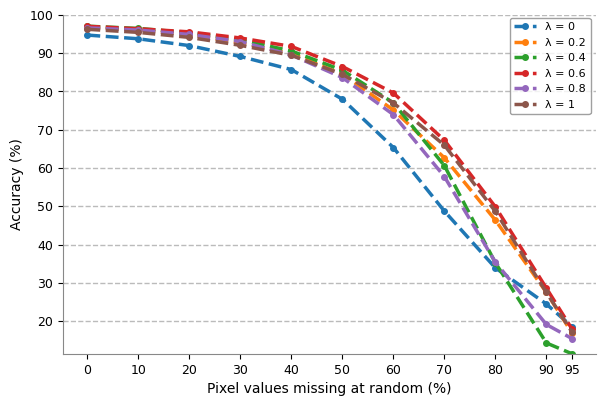

In [7]:
# convert missing rates to percentages
missing_rates_pct = [m * 100 for m in missing_rates]
lambda_dict_pct = {lam: (np.array(acc_dict[lam]) * 100) for lam in acc_dict}
sorted_lambdas = sorted(lambda_dict_pct.keys())
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(sorted_lambdas)))

plt.figure(figsize=(6, 4))
for idx, lam in enumerate(sorted_lambdas):
    acc_pct = lambda_dict_pct[lam]
    plt.plot(missing_rates_pct, acc_pct, linestyle='--', marker='o', markersize=4, linewidth=2.5, label=f"λ = {lam}",)

# axis labels
plt.xlabel("Pixel values missing at random (%)", fontsize=10)
plt.ylabel("Accuracy (%)", fontsize=10)

# x‐ticks
plt.xticks(missing_rates_pct, fontsize=9)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('#888888')
    ax.spines[spine].set_linewidth(0.8)

# dynamically y‐axis: from min accuracy up to 100%
all_acc_values = np.concatenate([lambda_dict_pct[lam] for lam in sorted_lambdas])
y_min = all_acc_values.min()
y_min_tick = int(np.floor(y_min / 10) * 10)
ax.set_yticks(np.arange(y_min_tick, 101, 10))
ax.yaxis.grid(True, linestyle='--', linewidth=1.0, color='#bbbbbb')
ax.set_ylim(y_min, 100)
plt.yticks(fontsize=9)

# force legend to appear in top right
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.0085), frameon=True, edgecolor='#888888', facecolor='white', fontsize=8)
plt.tight_layout(pad=0.5)

plt.savefig(f"figures/accuracies/accs_latent_dim_{latent_dim}.pdf")
plt.savefig(f"figures/accuracies/accs_latent_dim_{latent_dim}.png")
plt.show()

### Plot the same classification accuracies but for a zoomed in plot for clarity

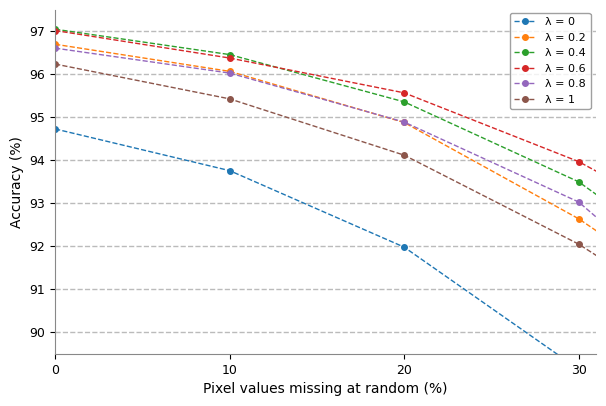

In [8]:
# convert missing rates to percentages
missing_rates_pct = [m * 100 for m in missing_rates]
lambda_dict_pct = {lam: (np.array(acc_dict[lam]) * 100) for lam in acc_dict}
sorted_lambdas = sorted(lambda_dict_pct.keys())
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(sorted_lambdas)))

plt.figure(figsize=(6, 4))
for idx, lam in enumerate(sorted_lambdas):
    acc_pct = lambda_dict_pct[lam]
    plt.plot(missing_rates_pct, acc_pct, linestyle='--', marker='o', markersize=4, linewidth=1.0, label=f"λ = {lam}",)

# axis labels
plt.xlabel("Pixel values missing at random (%)", fontsize=10)
plt.ylabel("Accuracy (%)", fontsize=10)

# x‐ticks
x_thresh = 31
ax = plt.gca()
ax.set_xticks(np.arange(0, x_thresh + 1, 10))
ax.set_xlim(0, x_thresh)
plt.xticks(fontsize=9)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('#888888')
    ax.spines[spine].set_linewidth(0.8)

# dynamically change y‐axis: from min accuracy up to 100%
all_acc_values = np.concatenate([lambda_dict_pct[lam] for lam in sorted_lambdas])
y_min = 89
y_min_tick = int(np.floor(y_min / 10) * 10)
ax.set_yticks(np.arange(y_min_tick, 101, 1))
ax.yaxis.grid(True, linestyle='--', linewidth=1.0, color='#bbbbbb')
ax.set_ylim(89.5, 97.5)
plt.yticks(fontsize=9)

# force legend to appear in top right
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.0085), frameon=True, edgecolor='#888888', facecolor='white', fontsize=8)
plt.tight_layout(pad=0.5)

plt.savefig(f"figures/accuracies/accs_latent_dim_{latent_dim}_zoomed.pdf")
plt.savefig(f"figures/accuracies/accs_latent_dim_{latent_dim}_zoomed.png")
plt.show()

### Evaluate sample quality

Plot a 3 by 3 grid of nine samples drawn from the model loaded most recently

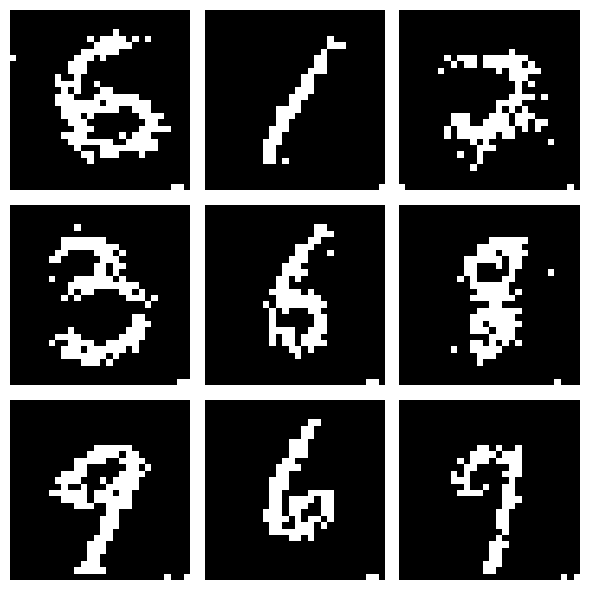

In [11]:
from random import sample

n_bins = 32
model.sampler.n_bins = n_bins
z, log_w = model.sampler(seed=42)
logits_tensor = model.decoder.net(z.to(device))
chosen_idxs = sample(range(n_bins), 9)

# 3 by 3 figure of samples
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
axes = axes.flatten()
for ax, idx in zip(axes, chosen_idxs):
    logits_sample = logits_tensor[idx]
    probs = torch.sigmoid(logits_sample)
    sample_flat = torch.bernoulli(probs)
    img = sample_flat.view(28, 28).detach().cpu().numpy()

    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()

plt.savefig(f"figures/samples/latent_dim_{latent_dim}/lam_{lamda:.1f}_latent_dim_{latent_dim}_samples.pdf")
# plt.savefig(f"figures/samples/latent_dim_{latent_dim}/lam_{lamda:.1f}_latent_dim_{latent_dim}_samples.png")
plt.show()

❗ fix up before meeting with Marco
### Plots of the mean and standard deviations of our Monte Carlo estimators for classification

In [ ]:
# from random import randint

# missing_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
# acc_dict = {k: [] for k in missing_rates}
# num_runs = 50 # each run takes ~30s w/ N=2^9 and ~?s w/ N=2^14

# for run in range(num_runs):
#     rand_seed = randint(1, 2 ** 32 - 2)
#     for missing_rate in missing_rates:
#         n_bins_list, acc_list, test_lls_list = compute_accuracies(
#             model=model,
#             X_test=X_test,
#             y_test=y_test,
#             lower_power_bound=8,
#             upper_power_bound=9,
#             latent_opt=False,
#             use_mnist=use_mnist,
#             missing_rate=missing_rate,
#             seed=rand_seed,
#         )
#         acc_dict[missing_rate].append(acc_list[0])

In [ ]:
# # missing percentages
# missing_rates = sorted(acc_dict)
# missing_pct = [m * 100 for m in missing_rates]

# # compute mean and std (%) for each missing rate
# means_pct = np.array([np.mean(acc_dict[m]) * 100 for m in missing_rates])
# stds_pct  = np.array([np.std(acc_dict[m], ddof=1) * 100 for m in missing_rates])
# print(means_pct, stds_pct)

# # upper and lower bounds
# upper = means_pct + stds_pct
# lower = means_pct - stds_pct

# # just plotting things, not too important to understand
# base_color = plt.cm.viridis(0.5)
# plt.figure(figsize=(6, 4))
# plt.fill_between(missing_pct, lower, upper, color=base_color, alpha=0.2) # shade region between the lower and upper lines
# plt.plot(missing_pct, means_pct, color=base_color, linestyle='-', marker='o', markersize=4, linewidth=2.5, label='Mean accuracy') # mean line
# plt.plot(missing_pct, upper, color=base_color, linestyle='--', linewidth=1) # upper line
# plt.plot(missing_pct, lower, color=base_color, linestyle='--', linewidth=1) # lower line
# plt.xlabel("Pixel values missing at random (%)", fontsize=10)
# plt.ylabel("Accuracy (%)", fontsize=10)
# plt.xticks(missing_pct, fontsize=9)
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# for spine in ['left', 'bottom']:
#     ax.spines[spine].set_color('#888888')
#     ax.spines[spine].set_linewidth(0.8)
# y_min = lower.min()
# y_min_tick = int(np.floor(y_min / 10) * 10)
# ax.set_yticks(np.arange(y_min_tick, 101, 10))
# ax.yaxis.grid(True, linestyle='--', linewidth=1.0, color='#bbbbbb')
# ax.set_ylim(y_min, 100)
# plt.yticks(fontsize=9)
# plt.legend(loc='upper right', bbox_to_anchor=(1, 1.0085), frameon=True, edgecolor='#888888', facecolor='white', fontsize=8)
# plt.tight_layout(pad=0.5)
# plt.show()

# ❗ To be removed at submission ❗
### Display just NLLs (this is to speed up obtaining them if needed)

In [ ]:
# n_bins_list = [2 ** k for k in range(8, 15)]
# seed=42
# seed_everything(seed=seed)

# # model hyperparams
# dataset = 'mnist' if use_mnist else 'bmnist'
# latent_dim = 32
# num_bins_trained = 8_192
# version_num = 0
# for lamda in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    
#     # load model
#     model_path = glob.glob(repo_dir+f'/logs/{dataset}/hybrid/latent_dim_{latent_dim}/num_bins_{num_bins_trained}/lambda_{lamda:.2f}/version_{version_num}/checkpoints/*.ckpt')[0]
#     model = ContinuousMixture.load_from_checkpoint(model_path).to(device)
#     model.n_chunks = 32
#     model.missing = False # this was True before, check if difference (hope not)
#     model.eval(); # semi-colon to prevent printing model architecture

#     out = ""
#     for n_bins in n_bins_list:
#         model.sampler.n_bins = n_bins
#         z, log_w = model.sampler(seed=seed)
#         test_ll = -model.eval_loader(test_loader, z, log_w, device=device).mean().item()
#         # print(f"Mean NLL for {n_bins:5d} components: {test_ll:6.2f}")
#         out += f"{test_ll:.2f} & "
#     print("\hline")
#     print(f"{lamda:.1f} & " + out[:-3] + 2 * "\\")